<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [4]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Install local canswim package

In [5]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./


Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done
  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


## Prepare Model

### Load Data

In [6]:
from canswim.model import CanswimModel

canswim_model = CanswimModel()


Configuring CUDA GPU
n_stocks:  20
n_epochs:  10


### Prepare Data

In [7]:

def prepare_data():
    canswim_model.prepare_data()
    canswim_model.plot_splits()
    canswim_model.plot_seasonality()



## Find optimal hyper parameters

In [8]:
# canswim_model.find_model()


In [9]:
# canswim_model.load_model()


## Build Model
  * Using optimal hyper parameters from study above

In [25]:

def build_new_model():
    canswim_model.build(            
                input_chunk_length=252,
                output_chunk_length=42,
                hidden_size=1536,
                num_encoder_layers=3,
                num_decoder_layers=3,
                decoder_output_dim=8,
                temporal_decoder_hidden=64,
                use_layer_norm=True,
                use_reversible_instance_norm=True,
                dropout=0.2,
                optimizer_kwargs={"lr": 3.5e-05},
    )
                # force_reset=False,
                # save_checkpoints=False)


## Train model

### Run model training loop

In [11]:
from darts.metrics import quantile_loss
import numpy as np


def plot_backtest_results():
    # backtest on 3 stocks
    for i in range(min(len(canswim_model.targets_list),3)):
        start_list = canswim_model.get_val_start_list()
        backtest = canswim_model.backtest(target=canswim_model.targets_list[i], start=start_list[i],
                                                    past_covariates=canswim_model.past_cov_list[i], future_covariates=canswim_model.future_cov_list[i],
                                                    forecast_horizon=canswim_model.pred_horizon)        
        # print(f"target series: \n{target}")
        # print(f"backtest series: \n{backtest}")
        loss_vals = []
        for p, b in enumerate(backtest):
            loss = quantile_loss(canswim_model.targets_list[i], b, n_jobs=-1, verbose=True)
            print(f"quantile loss: {loss} at prediction step {p}")
            loss_vals.append(loss)
        mean_loss = np.mean(loss_vals)
        print(f"Mean Backtest Quantile Loss across all prediction periods: {mean_loss}")
        canswim_model.plot_backtest_results(target=canswim_model.targets_list[i], 
                                            backtest=backtest, 
                                            start=start_list[i],
                                            forecast_horizon=canswim_model.pred_horizon)        


 

In [12]:
from darts.models import TiDEModel
from canswim.hfhub import HFHub
hfhub = HFHub()
repo_id = "ivelin/canswim"

In [13]:
canswim_model.download_model(repo_id=repo_id)    # prepare next sample subset


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
canswim_model.load_data()


n_stocks:  20
n_epochs:  10
Loaded 2650 symbols in total
Training loop stock subset has 20 tickers: 
 ['EFX', 'ASGN', 'PTGX', 'ALNT', 'UHS', 'BLK', 'SWKH', 'AVB', 'ACDC', 'FIP', 'HBT', 'MHK', 'GEO', 'CRWD', 'SIX', 'OTEX', 'PNM', 'LVS', 'ERJ', 'FTAI']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 20 stocks: 
['ACDC', 'ALNT', 'ASGN', 'AVB', 'BLK', 'CRWD', 'EFX', 'ERJ', 'FIP', 'FTAI', 'GEO', 'HBT', 'LVS', 'MHK', 'OTEX', 'PNM', 'PTGX', 'SIX', 'SWKH', 'UHS']
Skipping ACDC from price series. Not enough samples for model training.
Skipping FIP from price series. Not enough samples for model training.
Skipping HBT from price series. Not enough samples for model training.
Loading data from: data/data-3rd-party/earnings_calendar.parquet
pyarrow_filters: [('Symbol', 'in', ['EFX', 'ASGN', 'PTGX', 'ALNT', 'UHS', 'BLK', 'SWKH', 'AVB', 'ACDC', 'FIP', 'HBT', 'MHK', 'GEO', 'CRWD', 'SIX', 'OTEX', 'PNM', 'LVS', 'ERJ', 'FTAI'])]
Loadi

Preparing ticker series for 17 stocks.


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
Skipping ALNT due to error: 
"['ALNT'] not in index"
stacking covariates
Skipping ALNT covariates stack due to error:  'ALNT'
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
No analyst estimates available for ALNT
preparing future covariates: analyst estimates[annual]
No analyst estimates available for ALNT
stacking covariates
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'ALNT'}. Keeping {'SIX', 'UHS', 'MHK', 'EFX', 'ASGN', 'AVB', 'CRWD', 'SWKH', 'ERJ', 'PTGX', 'LVS', 'PNM', 'FTAI', 'OTEX', 'BLK', 'GEO'} 
Preparing train, val, test splits
preparing train, val and test splits
Removing CRWD from train set. Not enough samples. Minimum 1134 needed, but only 1046 available


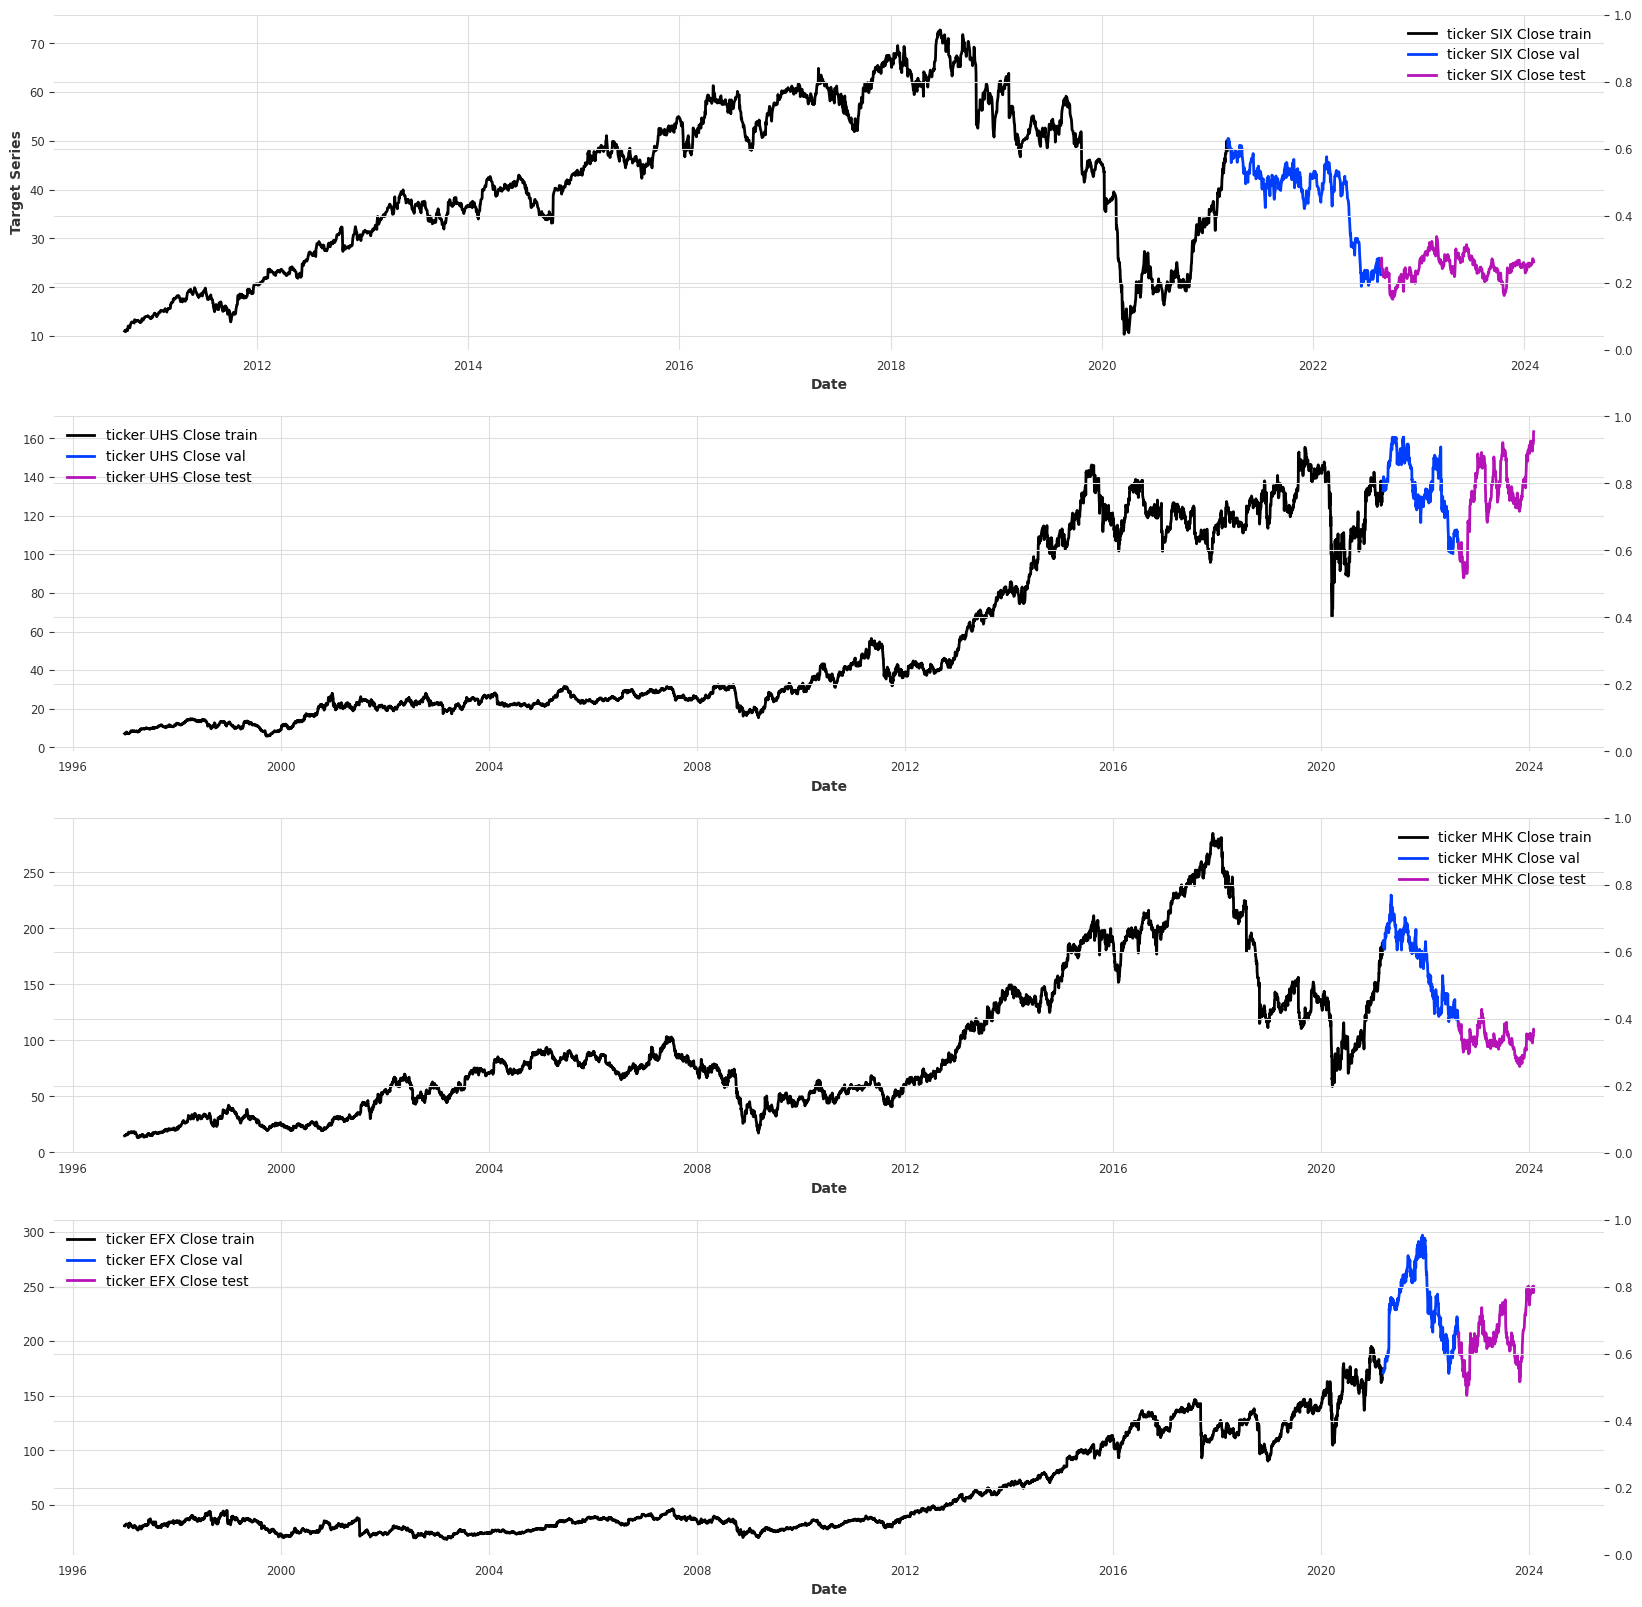

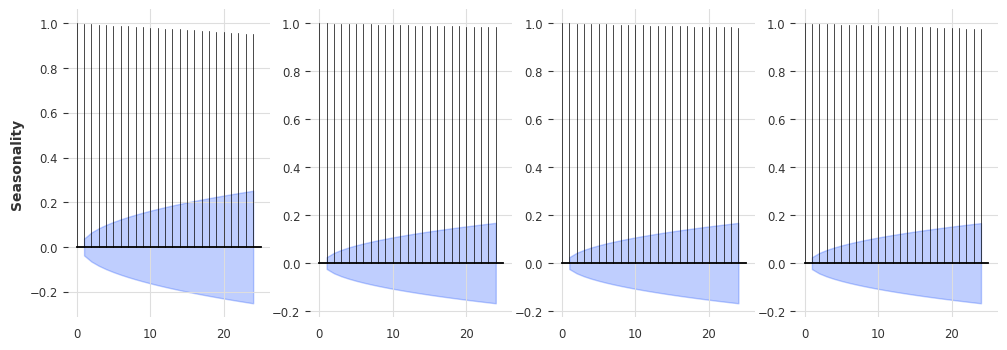

In [15]:
prepare_data()


In [16]:
targets = canswim_model.target_train_list[0].pd_dataframe()
past_covs = canswim_model.past_cov_list[0].pd_dataframe()
future_covs = canswim_model.future_cov_list[0].pd_dataframe()

In [26]:
# build_new_model()

Building a new model...
New model built.


In [35]:
import os
from dotenv import load_dotenv


global n_outer_train_loop
n_outer_train_loop = 1

def get_env():
    load_dotenv(override=True)
    global n_outer_train_loop
    n_outer_train_loop = int(os.getenv("n_outer_train_loop", 1))

get_env()

print("n_outer_train_loop:", n_outer_train_loop, type(n_outer_train_loop))

# train loop
i = 0
while i < n_outer_train_loop:
    print(f'Outer train loop: {i}')
    # load a new data sample from external source
    canswim_model.load_data()
    # prepare timeseries for training
    canswim_model.prepare_data()
    # train model
    canswim_model.train()
    # push to hf hub
    canswim_model.upload_model(repo_id=repo_id)
    # load back latest model weights from hf hub
    canswim_model.download_model(repo_id=repo_id)    # prepare next sample subset
    # refresh any config changes in the OS environment
    i += 1
    get_env()


n_outer_train_loop: 100 <class 'int'>
n_stocks:  5
n_epochs:  5
Loaded 2650 symbols in total
Training loop stock subset has 5 tickers: 
 ['FET', 'AURA', 'DFH', 'ACCD', 'USD']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 5 stocks: 
['ACCD', 'AURA', 'DFH', 'FET', 'USD']
Skipping ACCD from price series. Not enough samples for model training.
Skipping AURA from price series. Not enough samples for model training.
Skipping DFH from price series. Not enough samples for model training.
Loading data from: data/data-3rd-party/earnings_calendar.parquet
pyarrow_filters: [('Symbol', 'in', ['FET', 'AURA', 'DFH', 'ACCD', 'USD'])]
Loading a total of 115 unique earnings records
Loading data from: data/data-3rd-party/keymetrics_history.parquet
Loading data from: data/data-3rd-party/institutional_symbol_ownership.parquet
Loading data from: data/data-3rd-party/analyst_estimates_quarter.parquet
Loading data from: data/data-3rd-party/

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
Skipping USD due to error:  "['USD'] not in index"
stacking covariates
Skipping USD covariates stack due to error:  'USD'
preparing past covariates: key metrics
Skipping USD due to error:  "['USD'] not in index"
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
No analyst estimates available for USD
preparing future covariates: analyst estimates[annual]
No analyst estimates available for USD
stacking covariates
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'USD'}. Keeping {'FET'} 
Preparing train, val, test splits
preparing train, val and test splits
Starting model training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints/best-epoch=1-val_loss=23.46.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.


canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/893k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

canswim_model.pt:   0%|          | 0.00/893k [00:00<?, ?B/s]

canswim_model.pt.ckpt:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

n_stocks:  5
n_epochs:  5
Loaded 2650 symbols in total
Training loop stock subset has 5 tickers: 
 ['KAMN', 'PLBC', 'AZTA', 'PMTS', 'CZFS']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 5 stocks: 
['AZTA', 'CZFS', 'KAMN', 'PLBC', 'PMTS']
Loading data from: data/data-3rd-party/earnings_calendar.parquet
pyarrow_filters: [('Symbol', 'in', ['KAMN', 'PLBC', 'AZTA', 'PMTS', 'CZFS'])]
Loading a total of 493 unique earnings records
Loading data from: data/data-3rd-party/keymetrics_history.parquet
Loading data from: data/data-3rd-party/institutional_symbol_ownership.parquet
Loading data from: data/data-3rd-party/analyst_estimates_quarter.parquet
Loading data from: data/data-3rd-party/analyst_estimates_annual.parquet
Preparing ticker series for 5 stocks.


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
preparing future covariates: analyst estimates[annual]
stacking covariates
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'AZTA', 'PLBC'}. Keeping {'KAMN', 'CZFS', 'PMTS'} 
Preparing train, val, test splits
preparing train, val and test splits
Starting model training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints/best-epoch=2-val_loss=4.41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

n_stocks:  5
n_epochs:  5
Loaded 2650 symbols in total
Training loop stock subset has 5 tickers: 
 ['VIAV', 'BMI', 'KHC', 'PAHC', 'CVLY']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 5 stocks: 
['BMI', 'CVLY', 'KHC', 'PAHC', 'VIAV']
Loading data from: data/data-3rd-party/earnings_calendar.parquet
pyarrow_filters: [('Symbol', 'in', ['VIAV', 'BMI', 'KHC', 'PAHC', 'CVLY'])]
Loading a total of 526 unique earnings records
Loading data from: data/data-3rd-party/keymetrics_history.parquet
Loading data from: data/data-3rd-party/institutional_symbol_ownership.parquet
Loading data from: data/data-3rd-party/analyst_estimates_quarter.parquet
Loading data from: data/data-3rd-party/analyst_estimates_annual.parquet
Preparing ticker series for 5 stocks.


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
preparing future covariates: analyst estimates[annual]
stacking covariates
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'CVLY'}. Keeping {'PAHC', 'VIAV', 'BMI', 'KHC'} 
Preparing train, val, test splits
preparing train, val and test splits
Starting model training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints/best-epoch=2-val_loss=4.41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Model training finished.
Model saved.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

n_stocks:  20
n_epochs:  10
Loaded 2650 symbols in total
Training loop stock subset has 20 tickers: 
 ['GDYN', 'FOXF', 'CCNE', 'APTV', 'LGIH', 'MLKN', 'WEAV', 'CTBI', 'HIMS', 'EVTC', 'PSTX', 'QLYS', 'PLAY', 'CRNC', 'KMT', 'RNA', 'FROG', 'ORCL', 'CHCT', 'TRMB']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 20 stocks: 
['APTV', 'CCNE', 'CHCT', 'CRNC', 'CTBI', 'EVTC', 'FOXF', 'FROG', 'GDYN', 'HIMS', 'KMT', 'LGIH', 'MLKN', 'ORCL', 'PLAY', 'PSTX', 'QLYS', 'RNA', 'TRMB', 'WEAV']
Skipping CRNC from price series. Not enough samples for model training.
Skipping FROG from price series. Not enough samples for model training.
Skipping HIMS from price series. Not enough samples for model training.
Skipping PSTX from price series. Not enough samples for model training.
Skipping RNA from price series. Not enough samples for model training.
Skipping WEAV from price series. Not enough samples for model training.
Loading data from: 

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
preparing future covariates: analyst estimates[annual]
stacking covariates
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'MLKN', 'GDYN'}. Keeping {'APTV', 'LGIH', 'ORCL', 'FOXF', 'QLYS', 'CHCT', 'EVTC', 'CTBI', 'PLAY', 'KMT', 'CCNE', 'TRMB'} 
Preparing train, val, test splits
preparing train, val and test splits
Starting model training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints/best-epoch=2-val_loss=4.41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Model training finished.
Model saved.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

n_stocks:  20
n_epochs:  10
Loaded 2650 symbols in total
Training loop stock subset has 20 tickers: 
 ['GES', 'CAD', 'BOC', 'GRTS', 'PVH', 'MG', 'MYGN', 'MKC', 'GCO', 'TBBK', 'XOMA', 'IIPR', 'AMNB', 'TRS', 'MDGL', 'OCUL', 'NMIH', 'INTA', 'EAF', 'ASIX']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 20 stocks: 
['AMNB', 'ASIX', 'BOC', 'CAD', 'EAF', 'GCO', 'GES', 'GRTS', 'IIPR', 'INTA', 'MDGL', 'MG', 'MKC', 'MYGN', 'NMIH', 'OCUL', 'PVH', 'TBBK', 'TRS', 'XOMA']
Skipping CAD from price series. Not enough samples for model training.
Skipping INTA from price series. Not enough samples for model training.
Loading data from: data/data-3rd-party/earnings_calendar.parquet
pyarrow_filters: [('Symbol', 'in', ['GES', 'CAD', 'BOC', 'GRTS', 'PVH', 'MG', 'MYGN', 'MKC', 'GCO', 'TBBK', 'XOMA', 'IIPR', 'AMNB', 'TRS', 'MDGL', 'OCUL', 'NMIH', 'INTA', 'EAF', 'ASIX'])]
Loading a total of 1582 unique earnings records
Loading data from: dat

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
Skipping AMNB due to error:  "['AMNB'] not in index"
stacking covariates
Skipping AMNB covariates stack due to error:  'AMNB'
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
preparing future covariates: analyst estimates[annual]
stacking covariates
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'BOC', 'AMNB'}. Keeping {'EAF', 'MDGL', 'MKC', 'GCO', 'IIPR', 'NMIH', 'MYGN', 'XOMA', 'OCUL', 'GRTS', 'TBBK', 'ASIX', 'PVH', 'MG', 'TRS', 'GES'} 
Preparing train, val, test splits
preparing train, val and test splits
Starting model training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints/best-epoch=2-val_loss=4.41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Model training finished.
Model saved.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

n_stocks:  100
n_epochs:  10
Loaded 2650 symbols in total
Training loop stock subset has 100 tickers: 
 ['FIBK', 'CLDT', 'BBW', 'BRY', 'IPAR', 'WIX', 'SMR', 'HTBI', 'BRT', 'QRVO', 'MLP', 'CARE', 'HROW', 'BATRK', 'IBCP', 'VGR', 'CATC', 'DFIN', 'MED', 'GEHC', 'CNK', 'ATRO', 'JBL', 'WEST', 'PRA', 'PEP', 'RCKY', 'ZEUS', 'PRI', 'MGNI', 'FOLD', 'OPEN', 'LVS', 'MTX', 'LLY', 'SHOO', 'TPX', 'TAP', 'TTD', 'NECB', 'LH', 'TARO', 'JAKK', 'VNDA', 'MTH', 'SMMT', 'HRT', 'STE', 'INTC', 'USNA', 'BRZE', 'AVB', 'SSD', 'RILY', 'BWA', 'NEOG', 'AMGN', 'DKS', 'EUR', 'IRT', 'RDVT', 'REFI', 'MWA', 'STEM', 'MVIS', 'RAPT', 'ZTS', 'ETR', 'MTCH', 'VLO', 'WASH', 'SFNC', 'CNDT', 'INVH', 'CERS', 'SSBK', 'PX', 'ROST', 'PBPB', 'RMNI', 'AMAT', 'KLXE', 'AMRX', 'AIZ', 'DDS', 'MNTK', 'HLNE', 'AXON', 'CBAY', 'NAPA', 'AVY', 'TMST', 'MHK', 'WPM', 'CCBG', 'NNI', 'BTAI', 'EBF', 'HLVX', 'PFS']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 100 stocks: 
['AIZ',

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
Skipping JAKK due to error:  "['JAKK'] not in index"
stacking covariates
Skipping JAKK covariates stack due to error:  'JAKK'
preparing past covariates: institutional ownership of symbol
Skipping WASH due to error: 
"['WASH'] not in index"
stacking covariates
Skipping WASH covariates stack due to error:  'WASH'
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
No analyst estimates available for BATRK
No analyst estimates available for DFIN
No analyst estimates available for HLNE
No analyst estimates available for INVH
preparing future covariates: analyst estimates[annual]
No analyst estimates available for DFIN
No analyst estimates available for INVH
No analyst estimates available for MTCH
No analyst estimates available for RDVT
stacking covariates
Skipping MTCH covariates stack due to error:  'MTCH'
Skipping RDVT covariates stack due to error:  'RDVT'
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'RILY', 'CARE', 'WASH', 'INVH', 'BATRK', 'HLNE', 'NECB', 'MTCH', 'DFIN', 'RDVT', 'AXON', 'JAKK'}. Keeping {'USNA', 'TTD', 'DDS', 'ROST', 'CCBG', 'PRI', 'TAP', 'HROW', 'EBF', 'BRY', 'MGNI', 'TPX', 'STE', 'CNK', 'SSD', 'CLDT', 'MHK', 'QRVO', 'AMAT', 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints/best-epoch=2-val_loss=4.41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Model training finished.
Model saved.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

n_stocks:  100
n_epochs:  20
Loaded 2650 symbols in total
Training loop stock subset has 100 tickers: 
 ['BKSY', 'MBC', 'DOW', 'IBP', 'BKKT', 'BSRR', 'NEXT', 'NAT', 'PRLB', 'BBAI', 'TRGP', 'COGT', 'HGV', 'HAYN', 'BMY', 'BIGC', 'LC', 'KEY', 'LLY', 'NARI', 'ACDC', 'HSTM', 'CI', 'GLT', 'AGTI', 'CSV', 'ANET', 'CFG', 'NEOG', 'ANIK', 'RSVR', 'UCBI', 'PUMP', 'ALKT', 'QLYS', 'SLDP', 'CHCO', 'LOGI', 'FBMS', 'HEAR', 'MTSI', 'IT', 'OMI', 'KEYS', 'VBTX', 'GIC', 'SFIX', 'SVC', 'TT', 'WWW', 'UONE', 'DBX', 'CHCT', 'FIGS', 'CSGP', 'BBSI', 'FUL', 'PSTG', 'MACK', 'CARE', 'IRT', 'PGRE', 'TRMB', 'ETN', 'NCLH', 'ZETA', 'HTLF', 'LW', 'FSBC', 'KOS', 'CHRW', 'THRX', 'INFA', 'BIIB', 'COOP', 'RLAY', 'TG', 'EHTH', 'AXGN', 'AKAM', 'LUNA', 'CWK', 'SILK', 'SLRN', 'TCI', 'DEI', 'TENB', 'VGAS', 'LICY', 'DD', 'UVV', 'KODK', 'KALV', 'AI', 'B', 'PCOR', 'MRSN', 'ONL', 'HI', 'TGNA']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 100 stocks: 
['ACDC', '

/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
preparing model data
preparing past covariates
preparing past covariates: price and volume
preparing past covariates: earnings estimates 
stacking covariates
preparing past covariates: key metrics
stacking covariates
preparing past covariates: institutional ownership of symbol
stacking covariates
preparing past covariates: broad market indecies


/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/darts/timeseries.py:716: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xa = xr.DataArray(


stacking covariates
preparing future covariates
preparing future covariates: analyst estimates
preparing future covariates: analyst estimates[quarter]
No analyst estimates available for GIC
No analyst estimates available for KOS
No analyst estimates available for MRSN
preparing future covariates: analyst estimates[annual]
No analyst estimates available for GIC
No analyst estimates available for KOS
No analyst estimates available for TCI
stacking covariates
Skipping TCI covariates stack due to error:  'TCI'
preparing future covariates: holidays
Removing time series for tickers with incomplete data sets: {'CARE', 'KOS', 'TCI', 'UONE', 'MRSN', 'NEXT', 'DD', 'GIC'}. Keeping {'TENB', 'LW', 'B', 'CI', 'KODK', 'SVC', 'DOW', 'OMI', 'SILK', 'BBSI', 'BSRR', 'TRGP', 'PGRE', 'EHTH', 'HI', 'TRMB', 'BIIB', 'GLT', 'FBMS', 'ETN', 'PUMP', 'WWW', 'NCLH', 'IBP', 'CHRW', 'UCBI', 'DBX', 'HAYN', 'PSTG', 'TT', 'MTSI', 'PRLB', 'LUNA', 'UVV', 'VBTX', 'LOGI', 'DEI', 'ANIK', 'FUL', 'KEY', 'MACK', 'CFG', 'NAT', '

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ivelin/anaconda3/envs/canswim/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/ivelin/canswim/darts_logs/canswim_model.pt/checkpoints/best-epoch=2-val_loss=4.41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 274 K 
5 | future_cov_projection | _ResidualBlock   | 240 K 
6 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Model training finished.
Model saved.


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

n_stocks:  100
n_epochs:  20
Loaded 2650 symbols in total
Training loop stock subset has 100 tickers: 
 ['EQT', 'HLIT', 'EU', 'SIRI', 'RLYB', 'POR', 'RBCAA', 'JKHY', 'BLD', 'BTU', 'JBL', 'CIO', 'SYK', 'TTGT', 'AZN', 'QCOM', 'CCOI', 'NBTB', 'GMRE', 'ALT', 'DOV', 'LOCO', 'CMS', 'MCBC', 'MPLN', 'IGT', 'HON', 'RDFN', 'COR', 'MCB', 'NIC', 'TYRA', 'INN', 'KTB', 'BIRK', 'NOVT', 'AMKR', 'RL', 'VATE', 'NWFL', 'WMB', 'CARA', 'ABVX', 'PLL', 'DFLI', 'ASND', 'MBC', 'DKNG', 'HDSN', 'FOLD', 'AMR', 'PRME', 'PLYM', 'LUNG', 'IBM', 'STEP', 'ALGN', 'NXDT', 'MAX', 'BHLB', 'RHI', 'CDMO', 'ZBH', 'LLY', 'STEL', 'CASH', 'MITK', 'REX', 'FTV', 'RCKT', 'CCRD', 'NE', 'ESTC', 'DORM', 'NOC', 'COO', 'IRTC', 'ALX', 'PRDO', 'EBTC', 'SPLK', 'KDP', 'PFC', 'XPRO', 'KLIC', 'SBCF', 'BKSY', 'AKRO', 'ARM', 'PANW', 'INTU', 'PG', 'SANA', 'NUS', 'OXY', 'HROW', 'DGX', 'EWBC', 'AMD', 'SCHW']
Loading data from: data/data-3rd-party/all_stocks_price_hist_1d.parquet
filtered data loaded
price history loaded for 100 stocks: 
['ABVX', '

AssertionError: 

In [ ]:
canswim_model.targets.all_stock_tickers

In [ ]:
# backtest and plot results
plot_backtest_results()


In [ ]:

# quick test progress at modelcheckpoint
# preds = canswim_model.test()
# canswim_model.plot_test_results(preds)
